In [1]:
import os
from IPython.display import Audio
from scipy.io.wavfile import read
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import os


In [2]:
input_file=r'wavs\clean\clnsp0.wav'
ms=read(input_file)

In [3]:
ms[1].shape

(176320,)

In [4]:
sampFreq, snd =read(r'wavs\clean\clnsp0.wav')
write('test-2.wav',sampFreq,snd)

In [5]:
type(sampFreq),type(snd)

(int, numpy.ndarray)

# Preprocessing 

In [6]:
from math import ceil
def create_data_from_dir(dir_path,top_x=200,vector_min_size=5000):
    #dir_path directorio o folder donde estan los wavs
    # top_x opcional cuantos archivos maximo desea usar, dejar vacio para usarlos todos
    dir = os.listdir(dir_path)
    snd_list=[]
    s_rates=[]
    for i, file in enumerate(dir):
        if i<=top_x:
            input_file_path = os.path.join(dir_path, file)
            sampFreq, snd =read(input_file_path)
            num_batches=ceil(snd.shape[0]/vector_min_size) if snd.shape[0]>vector_min_size else 1
            ms=np.resize(snd,(vector_min_size*num_batches))
            batches=np.hsplit(ms,num_batches)
            for batch in batches:
                snd_list.append(batch)
                s_rates.append(sampFreq)
    return snd_list,s_rates

In [7]:
vector_min_size=2500
n_samples=2000
clean_specs,clean_s_rates=create_data_from_dir(r'wavs\clean',top_x=n_samples,vector_min_size=vector_min_size)
noisy_specs,noisy_s_rates=create_data_from_dir(r'wavs\noisy',top_x=n_samples,vector_min_size=vector_min_size)

In [8]:
cap=min(len(clean_specs),len(noisy_specs))
clean_specs=clean_specs[:cap]
noisy_specs=noisy_specs[:cap]

In [9]:
len(clean_specs),len(noisy_specs)

(102036, 102036)

In [10]:
clean_specs=np.array(clean_specs)
noisy_specs=np.array(noisy_specs)

## Datagenerator

In [11]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(noisy_specs, clean_specs, 32)

In [12]:
import os, shutil
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.layers import Dense,Flatten,Reshape,InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow
from PIL import Image
import re
from math import sqrt
from tensorflow.keras.applications import VGG16,ResNet50,MobileNet
from tensorflow.keras import layers, Model, Input

## Train function 

In [13]:
def train_model(model,epochs):
    my_callbacks = [
        #tf.keras.callbacks.ModelCheckpoint(filepath='callbacks/model.{epoch:02d}.h5')
        tf.keras.callbacks.ModelCheckpoint(
        #filepath='callbacks/model-{epoch:02d}-{loss:2f}.h5'
        filepath='callbacks/model.h5'
        ,monitor='loss'
        ,verbose=1
        ,save_weights_only=True
        ,save_best_only=True
        ,mode='min')
    ]
    
    history = model.fit(
                    train_gen
                    ,epochs=epochs
                    ,callbacks=my_callbacks
                    )
    
    plt.clf()
    plt.plot(history.history['loss'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(['Loss'], loc = 'upper left')

    return model,history

## Predict Function based on Audio sample

In [14]:
def clean_audio(audio_path, model,file_name):
    vector_min_size=2500
    preds=[]
    sampFreq, snd=read(audio_path)
    num_batches=ceil(snd.shape[0]/vector_min_size) if snd.shape[0]>vector_min_size else 1
    ms=np.resize(snd,(vector_min_size*num_batches))
    batches=np.hsplit(ms,num_batches)
    batches=np.array(batches)
    preds=model.predict(batches)
    preds=np.concatenate([pred for pred in preds])
    write(f'{file_name}.wav',sampFreq,preds)
    return preds

In [15]:
clean_specs.shape

(102036, 2500)

In [16]:
#adapted transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.05):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.num_heads=num_heads
        self.ff_dim=ff_dim
        self.rate=rate
        self.embed_dim=embed_dim
        
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,

        })
        return config

# Pool of models

In [30]:
def select_model(model_name,inputs,drop_out=0.1):

    image_side=int(sqrt(clean_specs.shape[-1]))
    image_dims=(image_side,image_side,1)


    if model_name=="naive":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Dense(64))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(64))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn1":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Dense(3000))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(1500))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(3000))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn2":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Dense(1024))
        model.add(layers.Dense(256))
        model.add(layers.Dense(128))
        model.add(layers.Dense(64))
        model.add(layers.Dense(128))
        model.add(layers.Dense(256))
        model.add(layers.Dense(320))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn3":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Dense(1024,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(64,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(320,activation="relu"))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn4":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Dense(3000,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(1500,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(3000,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn4_stacked2":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))

        model.add(layers.Dense(3000,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(1500,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(3000,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(1500,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(3000,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(1500,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(3000,activation="relu"))
        
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="dnn3_stacked2":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))

        model.add(layers.Dense(1024,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(64,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(320,activation="relu"))
        model.add(layers.Dense(1024,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(64,activation="relu"))
        model.add(layers.Dropout(drop_out))
        model.add(layers.Dense(128,activation="relu"))
        model.add(layers.Dense(256,activation="relu"))
        model.add(layers.Dense(320,activation="relu"))
        
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()

    elif model_name=="cnn1":

        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Reshape(image_dims))
        model.add(layers.Conv2D(filters = 32, kernel_size = (1,1),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 1, kernel_size = (3,3), padding = 'Same',
                        activation ='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="cnn2":
        model=models.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Reshape(image_dims))
        model.add(layers.Conv2D(filters = 32, kernel_size = (1,1),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.MaxPooling2D(2,strides=2))
        model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                        activation ='relu'))
        model.add(layers.UpSampling2D(2))
        model.add(layers.Conv2D(filters = 1, kernel_size = (3,3), padding = 'Same',
                        activation ='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(inputs))
        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    elif model_name=="VGG16":
        # model_VGG16=VGG16(weights='imagenet',include_top= False)
        # model_VGG16.trainable=False
        # model=models.Sequential()
        # model.add(layers.Input(shape=(inputs,)))
        # model.add(layers.Reshape(image_dims))
        # model.add(layers.UpSampling2D(5))
        # model.add(layers.Conv2D(filters = 3, kernel_size = (27,27),padding = 'Same', 
        #                 activation ='relu'))
        # model.add(model_VGG16)
        # model.add(layers.Flatten())
        # model.add(layers.Dense(1024))
        # model.add(layers.Dense(inputs))
        # model.compile(optimizer='adamax', loss='mse')
        # model.summary()

        Input_vector=keras.Input(shape=(inputs,))
        Input_img=keras.layers.Reshape(image_dims)(Input_vector)
        upscale=keras.layers.UpSampling2D(5)(Input_img)
        x1 = keras.layers.Conv2D(3, (27, 27), activation='relu', padding='valid')(upscale)


        model_transfer_test = keras.applications.VGG16(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False
        )
        model_transfer_test.trainable = False
        inputs_transfer = keras.Input(shape=(224, 224, 3))
        x = model_transfer_test(x1, training=False)
        #pooling layer 
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(1024, activation = 'softmax')(x)
        x = keras.layers.Dropout(drop_out, input_shape=(1024,))(x)
        #final dense layer
        outputs = keras.layers.Dense(inputs, activation = 'relu')(x)
        model = keras.Model(Input_vector,outputs)
        model.compile(optimizer='adam', loss = 'mse')
        model.summary()

    elif model_name=="MobileNet":
        Input_vector=keras.Input(shape=(inputs,))
        Input_img=keras.layers.Reshape(image_dims)(Input_vector)
        upscale=keras.layers.UpSampling2D(5)(Input_img)
        x1 = keras.layers.Conv2D(3, (27, 27), activation='relu', padding='valid')(upscale)


        model_transfer_test = keras.applications.MobileNet(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False
        )
        model_transfer_test.trainable = False
        inputs_transfer = keras.Input(shape=(224, 224, 3))
        x = model_transfer_test(x1, training=False)
        #pooling layer 
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(1024, activation = 'softmax')(x)
        x = keras.layers.Dropout(drop_out, input_shape=(1024,))(x)
        #final dense layer
        outputs = keras.layers.Dense(inputs, activation = 'relu')(x)
        model = keras.Model(Input_vector,outputs)
        model.compile(optimizer='adam', loss = 'mse')
        model.summary()
    elif model_name=="MobileNet_2":
        Input_vector=keras.Input(shape=(inputs,))
        Input_img=keras.layers.Reshape(image_dims)(Input_vector)
        upscale=keras.layers.UpSampling2D(3)(Input_img)
        x1 = keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(upscale)


        model_transfer_test = keras.applications.MobileNet(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
        )
        model_transfer_test.trainable = False
        inputs_transfer = keras.Input(shape=(150, 150, 3))
        x = model_transfer_test(x1, training=False)
        #pooling layer 
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(2500, activation = 'relu')(x)
        x = keras.layers.Dropout(drop_out, input_shape=(2500,))(x)

        #decoder
        x = keras.layers.Dense(1024, activation = 'relu')(x)
        x = keras.layers.Dense(256, activation = 'relu')(x)
        x = keras.layers.Dense(128, activation = 'relu')(x)
        x = keras.layers.Dense(64, activation = 'relu')(x)
        x = keras.layers.Dense(128, activation = 'relu')(x)
        x = keras.layers.Dense(256, activation = 'relu')(x)
        x = keras.layers.Dense(320, activation = 'relu')(x)


        # Input_img2=keras.layers.Reshape(image_dims)(x)
        # x1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(Input_img2)
        # x1 = keras.layers.UpSampling2D(2)(x1)
        # x2 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x1)
        # x2 = keras.layers.UpSampling2D(2)(x2)
        # x3 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x2)
        # x3 = keras.layers.UpSampling2D(2)(x3)
        # x4 = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x3)
        #flat = keras.layers.Flatten()(x4)
        #final dense layer
        outputs = keras.layers.Dense(inputs, activation = 'softmax')(x)
        model = keras.Model(Input_vector,outputs)
        model.compile(optimizer='adam', loss = 'mse')
        model.summary()
    elif model_name=="MobileNet_3":
        Input_vector=keras.Input(shape=(inputs,))
        Input_img=keras.layers.Reshape(image_dims)(Input_vector)
        x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(Input_img)
        x = keras.layers.MaxPooling2D(2,strides=2)(x)
        x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(2,strides=2)(x)
        x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(2,strides=2)(x)
        x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D(2)(x)
        x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D(2)(x)
        x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D(2)(x)
        x = keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

        upscale=keras.layers.UpSampling2D(4)(x)
        # x1 = keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(upscale)


        model_transfer_test = keras.applications.MobileNet(
        weights='imagenet',
        input_shape=(192, 192, 3),
        include_top=False
        )
        model_transfer_test.trainable = False
        inputs_transfer = keras.Input(shape=(192, 192, 3))
        x = model_transfer_test(upscale, training=False)
        #pooling layer 
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(300, activation = 'relu')(x)
        x = keras.layers.Dropout(drop_out, input_shape=(300,))(x)

        #decoder
        # x = keras.layers.Dense(1024, activation = 'relu')(x)
        # x = keras.layers.Dense(256, activation = 'relu')(x)
        # x = keras.layers.Dense(128, activation = 'relu')(x)
        # x = keras.layers.Dense(64, activation = 'relu')(x)
        # x = keras.layers.Dense(128, activation = 'relu')(x)
        # x = keras.layers.Dense(256, activation = 'relu')(x)
        # x = keras.layers.Dense(320, activation = 'relu')(x)


        # Input_img2=keras.layers.Reshape(image_dims)(x)
        # x1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(Input_img2)
        # x1 = keras.layers.UpSampling2D(2)(x1)
        # x2 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x1)
        # x2 = keras.layers.UpSampling2D(2)(x2)
        # x3 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x2)
        # x3 = keras.layers.UpSampling2D(2)(x3)
        # x4 = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x3)
        #flat = keras.layers.Flatten()(x4)
        #final dense layer
        outputs = keras.layers.Dense(inputs, activation = 'softmax')(x)
        model = keras.Model(Input_vector,outputs)
        model.compile(optimizer='adam', loss = 'mse')
        model.summary()
    elif model_name=="Transformer1":
        num_heads=3
        ff_dim=10

        model=keras.Sequential()
        model.add(layers.Input(shape=(inputs,)))
        model.add(layers.Reshape(image_dims))
        model.add(layers.Flatten()) 
        model.add(layers.Embedding(input_dim=(inputs),
                                         output_dim=20))

        model.add(TransformerBlock(20, num_heads, ff_dim,rate=drop_out))              
        model.add(layers.Dense(1))
        #model.add(layers.Dense(inputs))

        model.compile(optimizer='adamax', loss='mse')
        model.summary()
    return model


In [31]:
INPUTS=clean_specs.shape[-1]
custom_mobile_net=select_model("Transformer1",INPUTS,drop_out=0.1)
custom_mobile_net,history_custom_mobile_net=train_model(custom_mobile_net,10)
#2736502.5000

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 flatten_7 (Flatten)         (None, 2500)              0         
                                                                 
 embedding_4 (Embedding)     (None, 2500, 20)          50000     
                                                                 
 transformer_block_3 (Transf  (None, 2500, 20)         5510      
 ormerBlock)                                                     
                                                                 
 dense_14 (Dense)            (None, 2500, 1)           21        
                                                                 
Total params: 55,531
Trainable params: 55,531
Non-trainable params: 0
_________________________________________________

KeyboardInterrupt: 

# MLFLow Experimentation

## Custom crafted networks

### First Iteration

In [18]:
EPOCHS=100
MODELS=["naive","dnn1","dnn2","cnn1","cnn2"]
DROP_OUT=[0.1,0.5]
RUNS=3
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+"vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

2023/05/26 19:47:25 INFO mlflow.tracking.fluent: Experiment with name 'naivevector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                160064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2500)              162500    
                                                                 
Total params: 326,724
Trainable params: 326,724
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3174/3189 [============================>.] - ETA: 0s - loss: 2605078.0000
Epoch 1: loss improved from inf to 2602324.25000, saving model to callbacks\model.h5
3189/3189 [

2023/05/26 20:00:15 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 20:00:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmps2sh4u7w\model\data\model\assets


2023/05/26 20:00:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/05/26 20:01:01 INFO mlflow.tracking.fluent: Experiment with name 'naivevector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                160064    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 2500)              162500    
                                                                 
Total params: 326,724
Trainable params: 326,724
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3187/3189 [============================>.] - ETA: 0s - loss: 2722772.0000
Epoch 1: loss improved from inf to 2722473.50000, saving model to callbacks\model.h5
3189/3189

2023/05/26 20:13:52 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 20:13:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpse3yw75e\model\data\model\assets


2023/05/26 20:14:39 INFO mlflow.tracking.fluent: Experiment with name 'dnn1vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3000)              7503000   
                                                                 
 dropout_2 (Dropout)         (None, 3000)              0         
                                                                 
 dense_7 (Dense)             (None, 1500)              4501500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_8 (Dense)             (None, 3000)              4503000   
                                                                 
 dropout_4 (Dropout)         (None, 3000)              0         
                                                                 
 dense_9 (Dense)             (None, 2500)             

2023/05/26 20:34:59 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 20:34:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmps7r9jioq\model\data\model\assets


2023/05/26 20:36:14 INFO mlflow.tracking.fluent: Experiment with name 'dnn1vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 3000)              7503000   
                                                                 
 dropout_5 (Dropout)         (None, 3000)              0         
                                                                 
 dense_11 (Dense)            (None, 1500)              4501500   
                                                                 
 dropout_6 (Dropout)         (None, 1500)              0         
                                                                 
 dense_12 (Dense)            (None, 3000)              4503000   
                                                                 
 dropout_7 (Dropout)         (None, 3000)              0         
                                                                 
 dense_13 (Dense)            (None, 2500)             

2023/05/26 20:56:22 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 20:56:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpocstk9yw\model\data\model\assets


2023/05/26 20:57:07 INFO mlflow.tracking.fluent: Experiment with name 'dnn2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              2561024   
                                                                 
 dense_15 (Dense)            (None, 256)               262400    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 320)              

2023/05/26 21:16:20 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 21:16:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp_okbdfa6\model\data\model\assets


2023/05/26 21:16:53 INFO mlflow.tracking.fluent: Experiment with name 'dnn2vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1024)              2561024   
                                                                 
 dense_23 (Dense)            (None, 256)               262400    
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 256)               33024     
                                                                 
 dense_28 (Dense)            (None, 320)              

2023/05/26 21:35:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 21:35:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp8_xk00mc\model\data\model\assets


2023/05/26 21:39:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\USUARIO\AppData\Local\Temp\tmp8_xk00mc\model, flavor: tensorflow), fall back to return ['tensorflow==2.9.0']. Set logging level to DEBUG to see the full traceback.
2023/05/26 21:39:42 INFO mlflow.tracking.fluent: Experiment with name 'cnn1vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50, 50, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        64        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)      

2023/05/26 22:13:11 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 22:13:11 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7f4iasyi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7f4iasyi\model\data\model\assets
2023/05/26 22:14:01 INFO mlflow.tracking.fluent: Experiment with name 'cnn1vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        64        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 128)      

3183/3189 [============================>.] - ETA: 0s - loss: 2736875.5000
Epoch 1: loss improved from inf to 2736508.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 19s 6ms/step - loss: 2736508.5000
Epoch 2/100
3184/3189 [============================>.] - ETA: 0s - loss: 2736613.0000
Epoch 2: loss improved from 2736508.50000 to 2736507.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2736507.0000
Epoch 3/100
3183/3189 [============================>.] - ETA: 0s - loss: 2735947.2500
Epoch 3: loss did not improve from 2736507.00000
3189/3189 [==============================] - 16s 5ms/step - loss: 2736509.2500
Epoch 4/100
3180/3189 [============================>.] - ETA: 0s - loss: 2737578.5000
Epoch 4: loss improved from 2736507.00000 to 2736503.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2736503.0000
Epoch 5/100
3181/3189 [=====

2023/05/26 22:46:08 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 22:46:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp4ulbad_c\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp4ulbad_c\model\data\model\assets
2023/05/26 22:46:49 INFO mlflow.tracking.fluent: Experiment with name 'cnn2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 32)        64        
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 128)       147584    
                                                      

3186/3189 [============================>.] - ETA: 0s - loss: 2736242.7500
Epoch 1: loss improved from inf to 2736506.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 36s 10ms/step - loss: 2736506.2500
Epoch 2/100
3186/3189 [============================>.] - ETA: 0s - loss: 2736702.5000
Epoch 2: loss improved from 2736506.25000 to 2736503.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 29s 9ms/step - loss: 2736503.0000
Epoch 3/100
3184/3189 [============================>.] - ETA: 0s - loss: 2736609.5000
Epoch 3: loss did not improve from 2736503.00000
3189/3189 [==============================] - 30s 9ms/step - loss: 2736505.7500
Epoch 4/100
3186/3189 [============================>.] - ETA: 0s - loss: 2737202.2500
Epoch 4: loss did not improve from 2736503.00000
3189/3189 [==============================] - 31s 10ms/step - loss: 2736506.7500
Epoch 5/100
3186/3189 [============================>.] - ETA: 0s - loss:

2023/05/26 23:36:40 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/26 23:36:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp24pbejzk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp24pbejzk\model\data\model\assets
2023/05/26 23:37:51 INFO mlflow.tracking.fluent: Experiment with name 'cnn2vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 50, 50, 32)        64        
                                                                 
 conv2d_24 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 25, 25, 128)       147584    
                                                      

2023/05/27 00:26:56 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 00:26:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpy4h3nw1e\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpy4h3nw1e\model\data\model\assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                160064    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 2500)              162500    
                                                                 
Total params: 326,724
Trainable params: 326,724
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
   5/3189 [..............................] - ETA: 46s - loss: 3325607.0000    WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch tim

3186/3189 [============================>.] - ETA: 0s - loss: 2603394.0000
Epoch 1: loss improved from inf to 2602878.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 18s 4ms/step - loss: 2602878.5000
Epoch 2/100
3186/3189 [============================>.] - ETA: 0s - loss: 2449903.2500
Epoch 2: loss improved from 2602878.50000 to 2449336.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 8s 2ms/step - loss: 2449336.0000
Epoch 3/100
3180/3189 [============================>.] - ETA: 0s - loss: 2415777.5000
Epoch 3: loss improved from 2449336.00000 to 2414382.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 7s 2ms/step - loss: 2414382.2500
Epoch 4/100
3187/3189 [============================>.] - ETA: 0s - loss: 2397420.0000
Epoch 4: loss improved from 2414382.25000 to 2396892.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 7s 2ms/step - loss

2023/05/27 00:40:25 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 00:40:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmppmigv8ce\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmppmigv8ce\model\data\model\assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 64)                160064    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dense_39 (Dense)            (None, 2500)              162500    
                                                                 
Total params: 326,724
Trainable params: 326,724
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
   4/3189 [..............................] - ETA: 54s - loss: 6680369.5000     WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch ti

3185/3189 [============================>.] - ETA: 0s - loss: 2735385.7500
Epoch 1: loss improved from inf to 2735723.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 36s 3ms/step - loss: 2735723.2500
Epoch 2/100
3183/3189 [============================>.] - ETA: 0s - loss: 2587657.0000
Epoch 2: loss improved from 2735723.25000 to 2587661.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 7s 2ms/step - loss: 2587661.0000
Epoch 3/100
3178/3189 [============================>.] - ETA: 0s - loss: 2566821.5000
Epoch 3: loss improved from 2587661.00000 to 2569381.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 7s 2ms/step - loss: 2569381.7500
Epoch 4/100
3173/3189 [============================>.] - ETA: 0s - loss: 2563698.2500
Epoch 4: loss improved from 2569381.75000 to 2561474.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 7s 2ms/step - loss

2023/05/27 00:53:52 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 00:53:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpk384aee3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpk384aee3\model\data\model\assets


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 3000)              7503000   
                                                                 
 dropout_10 (Dropout)        (None, 3000)              0         
                                                                 
 dense_41 (Dense)            (None, 1500)              4501500   
                                                                 
 dropout_11 (Dropout)        (None, 1500)              0         
                                                                 
 dense_42 (Dense)            (None, 3000)              4503000   
                                                                 
 dropout_12 (Dropout)        (None, 3000)              0         
                                                                 
 dense_43 (Dense)            (None, 2500)            

2023/05/27 01:13:22 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 01:13:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpbm8o6lwx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpbm8o6lwx\model\data\model\assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 3000)              7503000   
                                                                 
 dropout_13 (Dropout)        (None, 3000)              0         
                                                                 
 dense_45 (Dense)            (None, 1500)              4501500   
                                                                 
 dropout_14 (Dropout)        (None, 1500)              0         
                                                                 
 dense_46 (Dense)            (None, 3000)              4503000   
                                                                 
 dropout_15 (Dropout)        (None, 3000)              0         
                                                                 
 dense_47 (Dense)            (None, 2500)            

3185/3189 [============================>.] - ETA: 0s - loss: 11107802.0000
Epoch 1: loss improved from inf to 11097644.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 11097644.0000
Epoch 2/100
3176/3189 [============================>.] - ETA: 0s - loss: 2844826.7500
Epoch 2: loss improved from 11097644.00000 to 2844393.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 4ms/step - loss: 2844393.7500
Epoch 3/100
3175/3189 [============================>.] - ETA: 0s - loss: 2639946.7500
Epoch 3: loss improved from 2844393.75000 to 2640636.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 4ms/step - loss: 2640636.5000
Epoch 4/100
3189/3189 [==============================] - ETA: 0s - loss: 2600215.0000
Epoch 4: loss improved from 2640636.50000 to 2600215.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step

2023/05/27 01:32:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 01:32:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn7lsf9ze\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn7lsf9ze\model\data\model\assets


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1024)              2561024   
                                                                 
 dense_49 (Dense)            (None, 256)               262400    
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 128)               8320      
                                                                 
 dense_53 (Dense)            (None, 256)               33024     
                                                                 
 dense_54 (Dense)            (None, 320)             

3180/3189 [============================>.] - ETA: 0s - loss: 2560252.0000
Epoch 1: loss improved from inf to 2560849.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 17s 3ms/step - loss: 2560849.0000
Epoch 2/100
3186/3189 [============================>.] - ETA: 0s - loss: 2389209.7500
Epoch 2: loss improved from 2560849.00000 to 2390110.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 10s 3ms/step - loss: 2390110.7500
Epoch 3/100
3176/3189 [============================>.] - ETA: 0s - loss: 2368434.0000
Epoch 3: loss improved from 2390110.75000 to 2366883.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 10s 3ms/step - loss: 2366883.2500
Epoch 4/100
3177/3189 [============================>.] - ETA: 0s - loss: 2355722.2500
Epoch 4: loss improved from 2366883.25000 to 2354738.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 9s 3ms/step - lo

2023/05/27 01:49:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 01:49:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpp7e1ckq1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpp7e1ckq1\model\data\model\assets


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 1024)              2561024   
                                                                 
 dense_57 (Dense)            (None, 256)               262400    
                                                                 
 dense_58 (Dense)            (None, 128)               32896     
                                                                 
 dense_59 (Dense)            (None, 64)                8256      
                                                                 
 dense_60 (Dense)            (None, 128)               8320      
                                                                 
 dense_61 (Dense)            (None, 256)               33024     
                                                                 
 dense_62 (Dense)            (None, 320)             

3181/3189 [============================>.] - ETA: 0s - loss: 2759942.0000
Epoch 1: loss improved from inf to 2758039.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 24s 3ms/step - loss: 2758039.7500
Epoch 2/100
3178/3189 [============================>.] - ETA: 0s - loss: 2418264.0000
Epoch 2: loss improved from 2758039.75000 to 2419434.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 10s 3ms/step - loss: 2419434.7500
Epoch 3/100
3179/3189 [============================>.] - ETA: 0s - loss: 2375783.2500
Epoch 3: loss improved from 2419434.75000 to 2375297.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 9s 3ms/step - loss: 2375297.2500
Epoch 4/100
3184/3189 [============================>.] - ETA: 0s - loss: 2361154.2500
Epoch 4: loss improved from 2375297.25000 to 2359499.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 9s 3ms/step - los

2023/05/27 02:05:54 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 02:05:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp6_rvcflb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp6_rvcflb\model\data\model\assets


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 32)        64        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 12, 12, 128)     

2023/05/27 02:32:29 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 02:32:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmptl308g4u\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmptl308g4u\model\data\model\assets


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 50, 50, 32)        64        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 12, 12, 128)     

3184/3189 [============================>.] - ETA: 0s - loss: 2737485.7500
Epoch 1: loss improved from inf to 2736505.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 17s 5ms/step - loss: 2736505.7500
Epoch 2/100
3189/3189 [==============================] - ETA: 0s - loss: 2736505.2500
Epoch 2: loss improved from 2736505.75000 to 2736505.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2736505.2500
Epoch 3/100
3186/3189 [============================>.] - ETA: 0s - loss: 2736879.5000
Epoch 3: loss improved from 2736505.25000 to 2736504.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2736504.7500
Epoch 4/100
3188/3189 [============================>.] - ETA: 0s - loss: 2736708.7500
Epoch 4: loss improved from 2736504.75000 to 2736503.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - l

2023/05/27 02:59:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 02:59:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpb_92g71b\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpb_92g71b\model\data\model\assets


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 50, 50, 1)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 50, 50, 32)        64        
                                                                 
 conv2d_47 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_48 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 25, 25, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 25, 25, 128)       147584    
                                                     

3184/3189 [============================>.] - ETA: 0s - loss: 2737587.2500
Epoch 1: loss improved from inf to 2736502.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 34s 9ms/step - loss: 2736502.5000
Epoch 2/100
3189/3189 [==============================] - ETA: 0s - loss: 2736504.5000
Epoch 2: loss did not improve from 2736502.50000
3189/3189 [==============================] - 28s 9ms/step - loss: 2736504.5000
Epoch 3/100
3184/3189 [============================>.] - ETA: 0s - loss: 2737407.2500
Epoch 3: loss did not improve from 2736502.50000
3189/3189 [==============================] - 28s 9ms/step - loss: 2736503.0000
Epoch 4/100
3189/3189 [==============================] - ETA: 0s - loss: 2736506.0000
Epoch 4: loss did not improve from 2736502.50000
3189/3189 [==============================] - 28s 9ms/step - loss: 2736506.0000
Epoch 5/100
3184/3189 [============================>.] - ETA: 0s - loss: 2736430.2500
Epoch 5: loss did not improve from

### Adjusting activations and dropout

2023/05/28 06:54:01 INFO mlflow.tracking.fluent: Experiment with name 'dnn3vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_112 (Dense)           (None, 256)               262400    
                                                                 
 dense_113 (Dense)           (None, 128)               32896     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_114 (Dense)           (None, 64)                8256      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_115 (Dense)           (None, 128)              

3183/3189 [============================>.] - ETA: 0s - loss: 2687807.5000
Epoch 1: loss improved from inf to 2687672.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 17s 4ms/step - loss: 2687672.5000
Epoch 2/100
3182/3189 [============================>.] - ETA: 0s - loss: 2596229.2500
Epoch 2: loss improved from 2687672.50000 to 2596205.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 10s 3ms/step - loss: 2596205.0000
Epoch 3/100
3177/3189 [============================>.] - ETA: 0s - loss: 2538013.5000
Epoch 3: loss improved from 2596205.00000 to 2537736.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2537736.7500
Epoch 4/100
3186/3189 [============================>.] - ETA: 0s - loss: 2492994.5000
Epoch 4: loss improved from 2537736.75000 to 2492932.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 10s 3ms/step - l

2023/05/28 07:12:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 07:12:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp8fwp_c1d\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp8fwp_c1d\model\data\model\assets
2023/05/28 07:12:55 INFO mlflow.tracking.fluent: Experiment with name 'dnn3vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_120 (Dense)           (None, 256)               262400    
                                                                 
 dense_121 (Dense)           (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_122 (Dense)           (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_123 (Dense)           (None, 128)              

3184/3189 [============================>.] - ETA: 0s - loss: 2731933.5000
Epoch 1: loss improved from inf to 2732545.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 18s 5ms/step - loss: 2732545.0000
Epoch 2/100
3185/3189 [============================>.] - ETA: 0s - loss: 2716018.2500
Epoch 2: loss improved from 2732545.00000 to 2716386.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2716386.7500
Epoch 3/100
3180/3189 [============================>.] - ETA: 0s - loss: 2698345.0000
Epoch 3: loss improved from 2716386.75000 to 2700120.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2700120.2500
Epoch 4/100
3176/3189 [============================>.] - ETA: 0s - loss: 2687057.0000
Epoch 4: loss improved from 2700120.25000 to 2688722.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 14s 4ms/step - l

2023/05/28 07:33:28 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 07:33:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn2ol_3zo\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn2ol_3zo\model\data\model\assets
2023/05/28 07:34:06 INFO mlflow.tracking.fluent: Experiment with name 'dnn4vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_38 (Dropout)        (None, 3000)              0         
                                                                 
 dense_128 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_39 (Dropout)        (None, 1500)              0         
                                                                 
 dense_129 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_40 (Dropout)        (None, 3000)              0         
                                                                 
 dense_130 (Dense)           (None, 2500)             

3187/3189 [============================>.] - ETA: 0s - loss: 2596019.2500
Epoch 1: loss improved from inf to 2595454.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2595454.5000
Epoch 2/100
3182/3189 [============================>.] - ETA: 0s - loss: 2258064.2500
Epoch 2: loss improved from 2595454.50000 to 2257566.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2257566.0000
Epoch 3/100
3177/3189 [============================>.] - ETA: 0s - loss: 2086660.7500
Epoch 3: loss improved from 2257566.00000 to 2085539.37500, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2085539.3750
Epoch 4/100
3176/3189 [============================>.] - ETA: 0s - loss: 1955290.5000
Epoch 4: loss improved from 2085539.37500 to 1956205.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - l

2023/05/28 07:54:45 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 07:54:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpk7933pww\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpk7933pww\model\data\model\assets
2023/05/28 07:55:38 INFO mlflow.tracking.fluent: Experiment with name 'dnn4vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_41 (Dropout)        (None, 3000)              0         
                                                                 
 dense_132 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_42 (Dropout)        (None, 1500)              0         
                                                                 
 dense_133 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_43 (Dropout)        (None, 3000)              0         
                                                                 
 dense_134 (Dense)           (None, 2500)             

3186/3189 [============================>.] - ETA: 0s - loss: 2744580.7500
Epoch 1: loss improved from inf to 2744546.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 21s 5ms/step - loss: 2744546.5000
Epoch 2/100
3186/3189 [============================>.] - ETA: 0s - loss: 2730445.5000
Epoch 2: loss improved from 2744546.50000 to 2729755.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2729755.2500
Epoch 3/100
3181/3189 [============================>.] - ETA: 0s - loss: 2714177.2500
Epoch 3: loss improved from 2729755.25000 to 2718289.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2718289.7500
Epoch 4/100
3178/3189 [============================>.] - ETA: 0s - loss: 2705589.2500
Epoch 4: loss improved from 2718289.75000 to 2705956.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - l

2023/05/28 08:16:36 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 08:16:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpgdmh318z\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpgdmh318z\model\data\model\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_136 (Dense)           (None, 256)               262400    
                                                                 
 dense_137 (Dense)           (None, 128)               32896     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_138 (Dense)           (None, 64)                8256      
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_139 (Dense)           (None, 128)              

3185/3189 [============================>.] - ETA: 0s - loss: 2684280.2500
Epoch 1: loss improved from inf to 2684348.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 25s 6ms/step - loss: 2684348.2500
Epoch 2/100
3189/3189 [==============================] - ETA: 0s - loss: 2589847.2500
Epoch 2: loss improved from 2684348.25000 to 2589847.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 14s 4ms/step - loss: 2589847.2500
Epoch 3/100
3176/3189 [============================>.] - ETA: 0s - loss: 2531411.0000
Epoch 3: loss improved from 2589847.25000 to 2531357.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2531357.2500
Epoch 4/100
3179/3189 [============================>.] - ETA: 0s - loss: 2489526.7500
Epoch 4: loss improved from 2531357.25000 to 2488829.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - l

2023/05/28 08:35:44 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 08:35:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7r5no623\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7r5no623\model\data\model\assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_144 (Dense)           (None, 256)               262400    
                                                                 
 dense_145 (Dense)           (None, 128)               32896     
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense_146 (Dense)           (None, 64)                8256      
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_147 (Dense)           (None, 128)              

3189/3189 [==============================] - ETA: 0s - loss: 2733869.0000
Epoch 1: loss improved from inf to 2733869.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 20s 5ms/step - loss: 2733869.0000
Epoch 2/100
3186/3189 [============================>.] - ETA: 0s - loss: 2719079.0000
Epoch 2: loss improved from 2733869.00000 to 2719731.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2719731.5000
Epoch 3/100
3187/3189 [============================>.] - ETA: 0s - loss: 2707494.0000
Epoch 3: loss improved from 2719731.50000 to 2706859.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2706859.5000
Epoch 4/100
3174/3189 [============================>.] - ETA: 0s - loss: 2693064.5000
Epoch 4: loss improved from 2706859.50000 to 2692324.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - l

2023/05/28 08:54:31 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 08:54:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0j3t08rr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0j3t08rr\model\data\model\assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_48 (Dropout)        (None, 3000)              0         
                                                                 
 dense_152 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_49 (Dropout)        (None, 1500)              0         
                                                                 
 dense_153 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_50 (Dropout)        (None, 3000)              0         
                                                                 
 dense_154 (Dense)           (None, 2500)             

3180/3189 [============================>.] - ETA: 0s - loss: 2492098.7500
Epoch 1: loss improved from inf to 2490334.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 67s 4ms/step - loss: 2490334.5000
Epoch 2/100
3182/3189 [============================>.] - ETA: 0s - loss: 2172377.5000
Epoch 2: loss improved from 2490334.50000 to 2172394.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2172394.0000
Epoch 3/100
3179/3189 [============================>.] - ETA: 0s - loss: 2013795.6250
Epoch 3: loss improved from 2172394.00000 to 2013390.62500, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2013390.6250
Epoch 4/100
3180/3189 [============================>.] - ETA: 0s - loss: 1902048.0000
Epoch 4: loss improved from 2013390.62500 to 1901825.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - l

2023/05/28 09:16:02 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 09:16:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp9d5h88vu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp9d5h88vu\model\data\model\assets


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_155 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_51 (Dropout)        (None, 3000)              0         
                                                                 
 dense_156 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_52 (Dropout)        (None, 1500)              0         
                                                                 
 dense_157 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_53 (Dropout)        (None, 3000)              0         
                                                                 
 dense_158 (Dense)           (None, 2500)             

3177/3189 [============================>.] - ETA: 0s - loss: 2740867.0000
Epoch 1: loss improved from inf to 2742079.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 17s 5ms/step - loss: 2742079.5000
Epoch 2/100
3180/3189 [============================>.] - ETA: 0s - loss: 2730893.0000
Epoch 2: loss improved from 2742079.50000 to 2730907.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2730907.0000
Epoch 3/100
3189/3189 [==============================] - ETA: 0s - loss: 2722665.7500
Epoch 3: loss improved from 2730907.00000 to 2722665.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2722665.7500
Epoch 4/100
3181/3189 [============================>.] - ETA: 0s - loss: 2713851.2500
Epoch 4: loss improved from 2722665.75000 to 2713389.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - l

2023/05/28 09:36:27 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 09:36:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpwob7zk0s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpwob7zk0s\model\data\model\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_160 (Dense)           (None, 256)               262400    
                                                                 
 dense_161 (Dense)           (None, 128)               32896     
                                                                 
 dropout_54 (Dropout)        (None, 128)               0         
                                                                 
 dense_162 (Dense)           (None, 64)                8256      
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_163 (Dense)           (None, 128)              

3183/3189 [============================>.] - ETA: 0s - loss: 2688613.7500
Epoch 1: loss improved from inf to 2688449.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 15s 3ms/step - loss: 2688449.7500
Epoch 2/100
3176/3189 [============================>.] - ETA: 0s - loss: 2597669.7500
Epoch 2: loss improved from 2688449.75000 to 2598079.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2598079.0000
Epoch 3/100
3177/3189 [============================>.] - ETA: 0s - loss: 2534536.0000
Epoch 3: loss improved from 2598079.00000 to 2535251.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - loss: 2535251.5000
Epoch 4/100
3176/3189 [============================>.] - ETA: 0s - loss: 2491567.5000
Epoch 4: loss improved from 2535251.50000 to 2489790.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 11s 3ms/step - l

2023/05/28 09:57:35 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 09:57:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp_8bgncsy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp_8bgncsy\model\data\model\assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_168 (Dense)           (None, 256)               262400    
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_170 (Dense)           (None, 64)                8256      
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_171 (Dense)           (None, 128)             

3189/3189 [==============================] - ETA: 0s - loss: 2733883.5000
Epoch 1: loss improved from inf to 2733883.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 22s 6ms/step - loss: 2733883.5000
Epoch 2/100
3182/3189 [============================>.] - ETA: 0s - loss: 2718458.0000
Epoch 2: loss improved from 2733883.50000 to 2721411.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2721411.7500
Epoch 3/100
3178/3189 [============================>.] - ETA: 0s - loss: 2702427.5000
Epoch 3: loss improved from 2721411.75000 to 2703988.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 14s 4ms/step - loss: 2703988.5000
Epoch 4/100
3182/3189 [============================>.] - ETA: 0s - loss: 2691040.5000
Epoch 4: loss improved from 2703988.50000 to 2690043.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - l

2023/05/28 10:17:23 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 10:17:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpx0xvhsqe\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpx0xvhsqe\model\data\model\assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_58 (Dropout)        (None, 3000)              0         
                                                                 
 dense_176 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_59 (Dropout)        (None, 1500)              0         
                                                                 
 dense_177 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_60 (Dropout)        (None, 3000)              0         
                                                                 
 dense_178 (Dense)           (None, 2500)            

3188/3189 [============================>.] - ETA: 0s - loss: 2635109.2500
Epoch 1: loss improved from inf to 2634729.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 38s 10ms/step - loss: 2634729.0000
Epoch 2/100
3178/3189 [============================>.] - ETA: 0s - loss: 2442418.0000
Epoch 2: loss improved from 2634729.00000 to 2442260.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 14s 4ms/step - loss: 2442260.7500
Epoch 3/100
3185/3189 [============================>.] - ETA: 0s - loss: 2299516.5000
Epoch 3: loss improved from 2442260.75000 to 2299239.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2299239.2500
Epoch 4/100
3189/3189 [==============================] - ETA: 0s - loss: 2185210.5000
Epoch 4: loss improved from 2299239.25000 to 2185210.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - 

2023/05/28 10:41:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 10:41:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmptr9upp74\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmptr9upp74\model\data\model\assets


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_179 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_61 (Dropout)        (None, 3000)              0         
                                                                 
 dense_180 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_62 (Dropout)        (None, 1500)              0         
                                                                 
 dense_181 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_63 (Dropout)        (None, 3000)              0         
                                                                 
 dense_182 (Dense)           (None, 2500)            

3181/3189 [============================>.] - ETA: 0s - loss: 2742201.0000
Epoch 1: loss improved from inf to 2742196.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 26s 6ms/step - loss: 2742196.5000
Epoch 2/100
3178/3189 [============================>.] - ETA: 0s - loss: 2734212.5000
Epoch 2: loss improved from 2742196.50000 to 2733304.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 12s 4ms/step - loss: 2733304.2500
Epoch 3/100
3181/3189 [============================>.] - ETA: 0s - loss: 2726029.7500
Epoch 3: loss improved from 2733304.25000 to 2724733.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - loss: 2724733.5000
Epoch 4/100
3180/3189 [============================>.] - ETA: 0s - loss: 2713569.7500
Epoch 4: loss improved from 2724733.50000 to 2713321.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 13s 4ms/step - l

2023/05/28 11:04:28 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 11:04:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp092qqeyg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp092qqeyg\model\data\model\assets


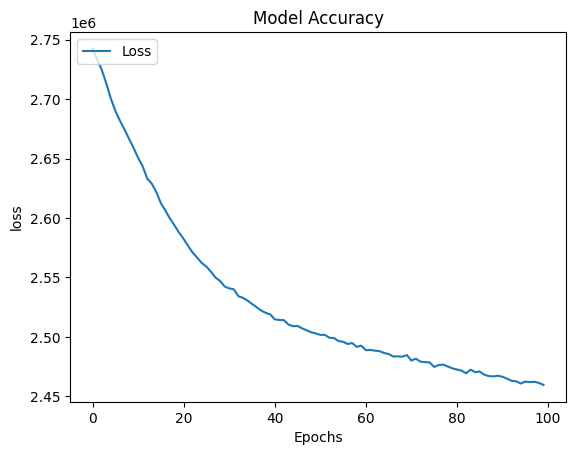

In [63]:
EPOCHS=100
MODELS=["dnn3","dnn4"]
DROP_OUT=[0.1,0.5]
RUNS=3
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+"vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

### stacked models

2023/05/28 11:51:41 INFO mlflow.tracking.fluent: Experiment with name 'dnn4_stacked2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_64 (Dropout)        (None, 3000)              0         
                                                                 
 dense_184 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_65 (Dropout)        (None, 1500)              0         
                                                                 
 dense_185 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_66 (Dropout)        (None, 3000)              0         
                                                                 
 dense_186 (Dense)           (None, 1500)            

2023/05/28 12:28:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 12:28:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpqqbfkcfc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpqqbfkcfc\model\data\model\assets
2023/05/28 12:30:19 INFO mlflow.tracking.fluent: Experiment with name 'dnn4_stacked2vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_191 (Dense)           (None, 3000)              7503000   
                                                                 
 dropout_71 (Dropout)        (None, 3000)              0         
                                                                 
 dense_192 (Dense)           (None, 1500)              4501500   
                                                                 
 dropout_72 (Dropout)        (None, 1500)              0         
                                                                 
 dense_193 (Dense)           (None, 3000)              4503000   
                                                                 
 dropout_73 (Dropout)        (None, 3000)              0         
                                                                 
 dense_194 (Dense)           (None, 1500)            

3187/3189 [============================>.] - ETA: 0s - loss: 2740108.7500
Epoch 1: loss improved from inf to 2739847.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 30s 8ms/step - loss: 2739847.2500
Epoch 2/100
3182/3189 [============================>.] - ETA: 0s - loss: 2732745.5000
Epoch 2: loss improved from 2739847.25000 to 2734099.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 18s 6ms/step - loss: 2734099.2500
Epoch 3/100
3185/3189 [============================>.] - ETA: 0s - loss: 2730564.0000
Epoch 3: loss improved from 2734099.25000 to 2729782.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 18s 6ms/step - loss: 2729782.2500
Epoch 4/100
3184/3189 [============================>.] - ETA: 0s - loss: 2725809.5000
Epoch 4: loss improved from 2729782.25000 to 2725458.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 18s 6ms/step - l

2023/05/28 13:02:48 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 13:02:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpjld_czp6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpjld_czp6\model\data\model\assets
2023/05/28 13:03:47 INFO mlflow.tracking.fluent: Experiment with name 'dnn3_stacked2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_200 (Dense)           (None, 256)               262400    
                                                                 
 dense_201 (Dense)           (None, 128)               32896     
                                                                 
 dropout_78 (Dropout)        (None, 128)               0         
                                                                 
 dense_202 (Dense)           (None, 64)                8256      
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
                                                                 
 dense_203 (Dense)           (None, 128)             

3189/3189 [==============================] - ETA: 0s - loss: 2726768.2500
Epoch 1: loss improved from inf to 2726768.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 37s 9ms/step - loss: 2726768.2500
Epoch 2/100
3184/3189 [============================>.] - ETA: 0s - loss: 2702217.2500
Epoch 2: loss improved from 2726768.25000 to 2703834.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 20s 6ms/step - loss: 2703834.0000
Epoch 3/100
3186/3189 [============================>.] - ETA: 0s - loss: 2683262.0000
Epoch 3: loss improved from 2703834.00000 to 2683075.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 20s 6ms/step - loss: 2683075.0000
Epoch 4/100
3189/3189 [==============================] - ETA: 0s - loss: 2664222.7500
Epoch 4: loss improved from 2683075.00000 to 2664222.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 19s 6ms/step - l

2023/05/28 13:37:44 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 13:37:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp4mj32ar3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp4mj32ar3\model\data\model\assets
2023/05/28 13:39:32 INFO mlflow.tracking.fluent: Experiment with name 'dnn3_stacked2vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100' does not exist. Creating a new experiment.


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_214 (Dense)           (None, 1024)              2561024   
                                                                 
 dense_215 (Dense)           (None, 256)               262400    
                                                                 
 dense_216 (Dense)           (None, 128)               32896     
                                                                 
 dropout_82 (Dropout)        (None, 128)               0         
                                                                 
 dense_217 (Dense)           (None, 64)                8256      
                                                                 
 dropout_83 (Dropout)        (None, 64)                0         
                                                                 
 dense_218 (Dense)           (None, 128)             

3186/3189 [============================>.] - ETA: 0s - loss: 2732595.7500
Epoch 1: loss improved from inf to 2732290.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 54s 12ms/step - loss: 2732290.7500
Epoch 2/100
3184/3189 [============================>.] - ETA: 0s - loss: 2727654.5000
Epoch 2: loss improved from 2732290.75000 to 2727802.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 20s 6ms/step - loss: 2727802.5000
Epoch 3/100
3185/3189 [============================>.] - ETA: 0s - loss: 2726322.2500
Epoch 3: loss improved from 2727802.50000 to 2726745.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - loss: 2726745.0000
Epoch 4/100
3186/3189 [============================>.] - ETA: 0s - loss: 2724548.2500
Epoch 4: loss improved from 2726745.00000 to 2725481.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 16s 5ms/step - 

2023/05/28 14:09:12 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 14:09:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp6pl96rjn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp6pl96rjn\model\data\model\assets


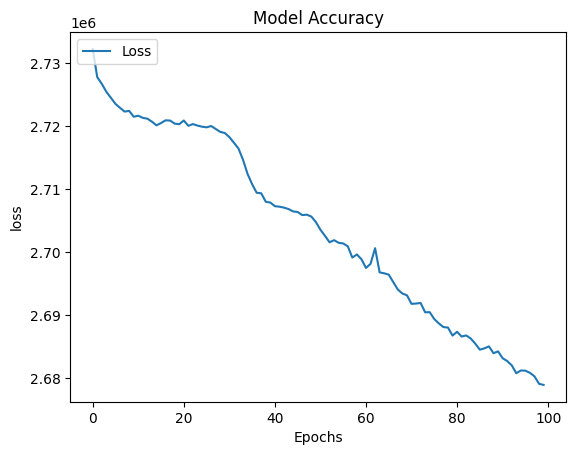

In [68]:
EPOCHS=100
MODELS=["dnn4_stacked2","dnn3_stacked2"]
DROP_OUT=[0.1,0.5]
RUNS=1
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+"vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

## VGG16

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_31 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_45 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_24  (None, 512)              0         
  (GlobalAveragePooling2D)                                

2023/05/28 03:02:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 03:02:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0mm09674\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0mm09674\model\data\model\assets


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_32 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_46 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_25  (None, 512)              0         
  (GlobalAveragePooling2D)                                

2023/05/28 04:26:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 04:26:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp_pgn4e53\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp_pgn4e53\model\data\model\assets


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_33 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_47 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_26  (None, 512)              0         
  (GlobalAveragePooling2D)                                

2023/05/28 05:50:02 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 05:50:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp792373wm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp792373wm\model\data\model\assets


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_82 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_34 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_48 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_27  (None, 512)              0         
  (GlobalAveragePooling2D)                                

3189/3189 [==============================] - ETA: 0s - loss: 2736506.0000
Epoch 1: loss improved from inf to 2736506.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 260s 81ms/step - loss: 2736506.0000
Epoch 2/20
1968/3189 [=================>............] - ETA: 1:37 - loss: 2699776.2500

KeyboardInterrupt: 

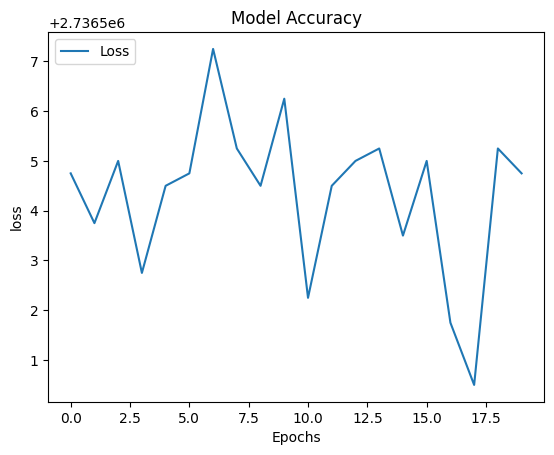

In [42]:
EPOCHS=20
#MODELS=["naive","dnn1","dnn2","cnn1","cnn2"]
MODELS=["VGG16"]
DROP_OUT=[0.1,0.5]
RUNS=2
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+" vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

## MobileNet

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_27 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_41 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_20  (None, 1024)             0  

3188/3189 [============================>.] - ETA: 0s - loss: 2736951.2500
Epoch 1: loss improved from inf to 2736504.50000, saving model to callbacks\model.h5
3189/3189 [==============================] - 104s 32ms/step - loss: 2736504.5000
Epoch 2/20
3189/3189 [==============================] - ETA: 0s - loss: 2736506.2500
Epoch 2: loss did not improve from 2736504.50000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736506.2500
Epoch 3/20
3189/3189 [==============================] - ETA: 0s - loss: 2736507.2500
Epoch 3: loss did not improve from 2736504.50000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736507.2500
Epoch 4/20
3189/3189 [==============================] - ETA: 0s - loss: 2736505.0000
Epoch 4: loss did not improve from 2736504.50000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736505.0000
Epoch 5/20
3189/3189 [==============================] - ETA: 0s - loss: 2736502.7500
Epoch 5: loss improved from 27

2023/05/27 23:56:42 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 23:56:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0ccs32ey\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp0ccs32ey\model\data\model\assets


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_28 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_42 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_21  (None, 1024)             0  

3189/3189 [==============================] - ETA: 0s - loss: 2736504.0000
Epoch 1: loss improved from inf to 2736504.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 104s 32ms/step - loss: 2736504.0000
Epoch 2/20
3189/3189 [==============================] - ETA: 0s - loss: 2736504.7500
Epoch 2: loss did not improve from 2736504.00000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736504.7500
Epoch 3/20
3189/3189 [==============================] - ETA: 0s - loss: 2736506.0000
Epoch 3: loss did not improve from 2736504.00000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736506.0000
Epoch 4/20
3189/3189 [==============================] - ETA: 0s - loss: 2736503.0000
Epoch 4: loss improved from 2736504.00000 to 2736503.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 101s 32ms/step - loss: 2736503.0000
Epoch 5/20
3189/3189 [==============================] - ETA: 0s - los

2023/05/28 00:30:52 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 00:30:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpzx5b06d6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpzx5b06d6\model\data\model\assets


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_29 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_43 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_22  (None, 1024)             0  

3189/3189 [==============================] - ETA: 0s - loss: 2736506.2500
Epoch 1: loss improved from inf to 2736506.25000, saving model to callbacks\model.h5
3189/3189 [==============================] - 105s 32ms/step - loss: 2736506.2500
Epoch 2/20
3189/3189 [==============================] - ETA: 0s - loss: 2736502.7500
Epoch 2: loss improved from 2736506.25000 to 2736502.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 101s 32ms/step - loss: 2736502.7500
Epoch 3/20
3189/3189 [==============================] - ETA: 0s - loss: 2736505.0000
Epoch 3: loss did not improve from 2736502.75000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736505.0000
Epoch 4/20
3189/3189 [==============================] - ETA: 0s - loss: 2736503.7500
Epoch 4: loss did not improve from 2736502.75000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736503.7500
Epoch 5/20
3189/3189 [==============================] - ETA: 0s - los

2023/05/28 01:05:03 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 01:05:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7ci9n146\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmp7ci9n146\model\data\model\assets


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_30 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_44 (UpSamplin  (None, 250, 250, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 224, 224, 3)       2190      
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_23  (None, 1024)             0  

3189/3189 [==============================] - ETA: 0s - loss: 2736507.0000
Epoch 1: loss improved from inf to 2736507.00000, saving model to callbacks\model.h5
3189/3189 [==============================] - 103s 32ms/step - loss: 2736507.0000
Epoch 2/20
3189/3189 [==============================] - ETA: 0s - loss: 2736501.7500
Epoch 2: loss improved from 2736507.00000 to 2736501.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 101s 32ms/step - loss: 2736501.7500
Epoch 3/20
3189/3189 [==============================] - ETA: 0s - loss: 2736505.2500
Epoch 3: loss did not improve from 2736501.75000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736505.2500
Epoch 4/20
3189/3189 [==============================] - ETA: 0s - loss: 2736505.2500
Epoch 4: loss did not improve from 2736501.75000
3189/3189 [==============================] - 101s 32ms/step - loss: 2736505.2500
Epoch 5/20
3189/3189 [==============================] - ETA: 0s - los

2023/05/28 01:39:08 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/28 01:39:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpu75eevox\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpu75eevox\model\data\model\assets


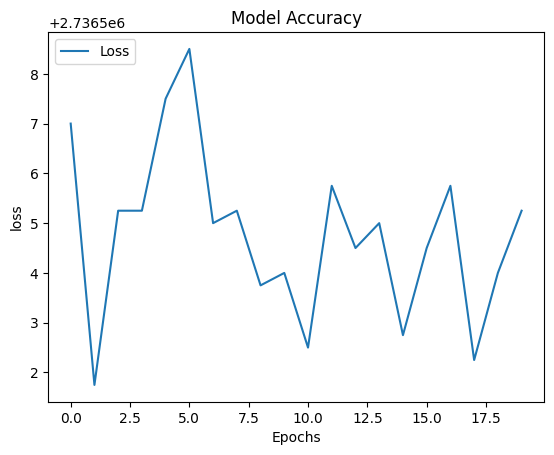

In [41]:
EPOCHS=20
#MODELS=["naive","dnn1","dnn2","cnn1","cnn2"]
MODELS=["MobileNet"]
DROP_OUT=[0.1,0.5]
RUNS=2
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+" vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

## MobileNet ajusted decoder

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_23 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_37 (UpSamplin  (None, 150, 150, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 150, 150, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_16  (None, 1024)             0  

2023/05/27 22:22:58 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 22:22:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpp45wf6qs\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpp45wf6qs\model\data\model\assets
2023/05/27 22:24:09 INFO mlflow.tracking.fluent: Experiment with name 'MobileNet_2 vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 20' does not exist. Creating a new experiment.


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_24 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_38 (UpSamplin  (None, 150, 150, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 150, 150, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_17  (None, 1024)             0  

3188/3189 [============================>.] - ETA: 0s - loss: 2735987.2500
Epoch 1: loss improved from inf to 2736505.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 67s 21ms/step - loss: 2736505.7500
Epoch 2/20
3187/3189 [============================>.] - ETA: 0s - loss: 2736913.7500
Epoch 2: loss improved from 2736505.75000 to 2736503.75000, saving model to callbacks\model.h5
3189/3189 [==============================] - 57s 18ms/step - loss: 2736503.7500
Epoch 3/20
3189/3189 [==============================] - ETA: 0s - loss: 2736505.0000
Epoch 3: loss did not improve from 2736503.75000
3189/3189 [==============================] - 57s 18ms/step - loss: 2736505.0000
Epoch 4/20
3189/3189 [==============================] - ETA: 0s - loss: 2736504.0000
Epoch 4: loss did not improve from 2736503.75000
3189/3189 [==============================] - 59s 19ms/step - loss: 2736504.0000
Epoch 5/20
3189/3189 [==============================] - ETA: 0s - loss: 2

2023/05/27 22:43:39 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 22:43:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpj_uf3guk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpj_uf3guk\model\data\model\assets


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_25 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_39 (UpSamplin  (None, 150, 150, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 150, 150, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_18  (None, 1024)             0  

2023/05/27 23:03:09 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 23:03:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn5u4ewh9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpn5u4ewh9\model\data\model\assets


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 2500)]            0         
                                                                 
 reshape_26 (Reshape)        (None, 50, 50, 1)         0         
                                                                 
 up_sampling2d_40 (UpSamplin  (None, 150, 150, 1)      0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 150, 150, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_19  (None, 1024)             0  

2023/05/27 23:22:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/05/27 23:22:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpeibxb_st\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\USUARIO\AppData\Local\Temp\tmpeibxb_st\model\data\model\assets


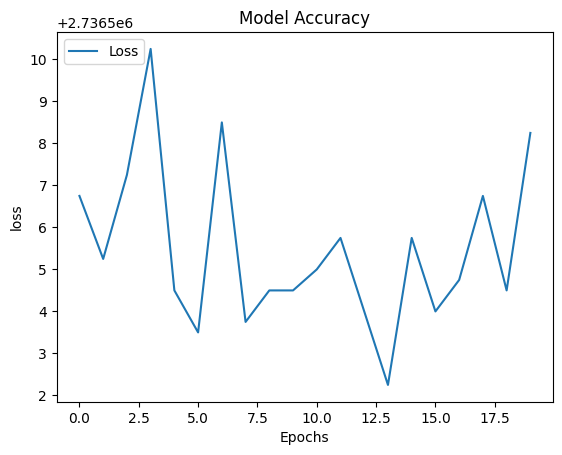

In [40]:
EPOCHS=20
#MODELS=["naive","dnn1","dnn2","cnn1","cnn2"]
MODELS=["MobileNet_2"]
DROP_OUT=[0.1,0.5]
RUNS=2
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+" vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

## Transformers

In [ ]:
EPOCHS=10
#MODELS=["naive","dnn1","dnn2","cnn1","cnn2"]
MODELS=["Transformer1"]
DROP_OUT=[0.05,0.1]
RUNS=1
INPUTS=clean_specs.shape[-1]
for r in range(RUNS):
    for m in MODELS:
        for drop_out in DROP_OUT:
            mlflow.set_experiment(m+" vector_min_size "+str(vector_min_size)+" n_samples "+str(n_samples)+ " dropout "+str(drop_out)+" epochs "+str(EPOCHS))
            with mlflow.start_run():
                mlflow.tensorflow.autolog()
                model=select_model(m,INPUTS,drop_out=drop_out)
                model,history=train_model(model,EPOCHS)
                
                directory='callbacks'
                for filename in os.listdir(directory):
                    #print ('callbacks/model.'+str(file)+'.h5')
                    f = os.path.join(directory, filename)
                    mlflow.log_artifact(f)
                    
                
                for filename in os.listdir(directory):
                    f = os.path.join(directory, filename)
                    os.remove(f)

                mlflow.log_artifact("Training Plot.png")
            mlflow.end_run()

# Results Analysis

## Extracting information from MLFLOW

In [69]:
import mlflow
import pandas as pd
from mlflow.entities import ViewType

In [71]:
experiments = mlflow.search_experiments(view_type=ViewType.ALL)
runs=[]
for exp in experiments:
    e_id=exp.experiment_id
    run=mlflow.search_runs(experiment_ids=[e_id])
    run["experiment_name"]=exp.name
    runs.append(run)
runs=pd.concat(runs)

Runs estructure

In [72]:
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss,params.shuffle,params.opt_name,params.use_multiprocessing,...,params.steps_per_epoch,params.opt_beta_2,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,experiment_name,params.opt_amsgrad,tags.mlflow.autologging
0,e88da3699b9b4d59b1fb64aea2b36c83,428376191294209169,FINISHED,file:///c:/Users/USUARIO/Desktop/DeepLearning/...,2023-05-28 18:39:33.303000+00:00,2023-05-28 19:11:12.486000+00:00,2678950.000,True,Adamax,False,...,None,0.999,USUARIO,"[{""run_id"": ""e88da3699b9b4d59b1fb64aea2b36c83""...",melodic-doe-934,LOCAL,c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\si...,dnn3_stacked2vector_min_size 2500 n_samples 20...,NaN,NaN
0,54bd0394bcbd468db399a95ee5f7da51,817120816286958842,FINISHED,file:///c:/Users/USUARIO/Desktop/DeepLearning/...,2023-05-28 18:03:47.530000+00:00,2023-05-28 18:39:32.660000+00:00,2200215.250,True,Adamax,False,...,None,0.999,USUARIO,"[{""run_id"": ""54bd0394bcbd468db399a95ee5f7da51""...",luminous-robin-979,LOCAL,c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\si...,dnn3_stacked2vector_min_size 2500 n_samples 20...,NaN,NaN
0,e74d2d87fe2d48a494fd1bf82170c273,183422633024821028,FINISHED,file:///c:/Users/USUARIO/Desktop/DeepLearning/...,2023-05-28 17:30:20.296000+00:00,2023-05-28 18:03:47.104000+00:00,2459763.250,True,Adamax,False,...,None,0.999,USUARIO,"[{""run_id"": ""e74d2d87fe2d48a494fd1bf82170c273""...",bold-jay-32,LOCAL,c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\si...,dnn4_stacked2vector_min_size 2500 n_samples 20...,NaN,NaN
0,ff8bb6a7956d464ca77cf32be7adf88b,377535757391431788,FINISHED,file:///c:/Users/USUARIO/Desktop/DeepLearning/...,2023-05-28 16:51:42.075000+00:00,2023-05-28 17:30:19.362000+00:00,1272539.125,True,Adamax,False,...,None,0.999,USUARIO,"[{""run_id"": ""ff8bb6a7956d464ca77cf32be7adf88b""...",overjoyed-cub-796,LOCAL,c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\si...,dnn4_stacked2vector_min_size 2500 n_samples 20...,NaN,NaN
0,6c5b475716224de99333e82f4935f763,133066846081328314,FINISHED,file:///c:/Users/USUARIO/Desktop/DeepLearning/...,2023-05-28 15:42:37.148000+00:00,2023-05-28 16:05:39.887000+00:00,2459603.500,True,Adamax,False,...,None,0.999,USUARIO,"[{""run_id"": ""6c5b475716224de99333e82f4935f763""...",powerful-gnu-547,LOCAL,c:\Users\USUARIO\anaconda3\envs\gpu_env\lib\si...,dnn4vector_min_size 2500 n_samples 2000 dropou...,NaN,NaN


In [73]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.loss', 'params.shuffle', 'params.opt_name',
       'params.use_multiprocessing', 'params.batch_size', 'params.opt_decay',
       'params.validation_steps', 'params.class_weight', 'params.opt_beta_1',
       'params.sample_weight', 'params.initial_epoch', 'params.max_queue_size',
       'params.validation_split', 'params.opt_learning_rate',
       'params.opt_epsilon', 'params.epochs', 'params.workers',
       'params.validation_batch_size', 'params.validation_freq',
       'params.steps_per_epoch', 'params.opt_beta_2', 'tags.mlflow.user',
       'tags.mlflow.log-model.history', 'tags.mlflow.runName',
       'tags.mlflow.source.type', 'tags.mlflow.source.name', 'experiment_name',
       'params.opt_amsgrad', 'tags.mlflow.autologging'],
      dtype='object')

## Reference table for making easier to track experiments by name instead by ID

In [77]:
ref_experiments=runs.groupby(["experiment_name","run_id"]).agg({"experiment_id":"count"}).reset_index()
ref_experiments.head()

,experiment_name,run_id,experiment_id
0,MobileNet vector_min_size 2500 n_samples 2000 ...,4472f60e3cb54d76aefb67bcdefa0ee0,1
1,MobileNet vector_min_size 2500 n_samples 2000 ...,5945ba3415fd4fea9ca7955ecfbfc108,1
2,MobileNet vector_min_size 2500 n_samples 2000 ...,b436ef42b5004d33b2c6a611c31a8908,1
3,MobileNet vector_min_size 2500 n_samples 2000 ...,df6f0ffd04274475b1e7dfa36f5c02eb,1
4,MobileNet vector_min_size 2500 n_samples 2000 ...,52021dabac544d62a3cf256cd3823bdc,1


## Getting best experiments by loss
As we can see the dnn4 configuration has the best performance, followed by our custom CNN

In [93]:
top10_experiments=runs.groupby(["experiment_name","run_id"])["metrics.loss"].aggregate(['min']).reset_index().sort_values("min").head(10)
top10_experiments

,experiment_name,run_id,min
78,dnn4vector_min_size 2500 n_samples 2000 dropou...,f58987e01c624d48ba905c8aa4397406,1.033604e+06
76,dnn4vector_min_size 2500 n_samples 2000 dropou...,5b4215c79e9b4c049c37477bc6affad7,1.046480e+06
77,dnn4vector_min_size 2500 n_samples 2000 dropou...,aca9a94dc968481598e70225118bbfd9,1.088232e+06
74,dnn4_stacked2vector_min_size 2500 n_samples 20...,ff8bb6a7956d464ca77cf32be7adf88b,1.272539e+06
32,cnn1vector_min_size 2500 n_samples 2000 dropou...,7de0e722f0b94c8fa6eed03d15f84aae,1.435283e+06
33,cnn1vector_min_size 2500 n_samples 2000 dropou...,ba1cfe393b3f42d1b361c3a226669416,1.447092e+06
70,dnn3vector_min_size 2500 n_samples 2000 dropou...,d2d8ae3f33364a4bba6f36f537c523b0,1.898246e+06
68,dnn3vector_min_size 2500 n_samples 2000 dropou...,09a558c7b4c04754a74b49e54793bcee,1.901299e+06
69,dnn3vector_min_size 2500 n_samples 2000 dropou...,68d38fd565774adb88a0eabd3fb947fe,1.906601e+06
21,VGG16 vector_min_size 2500 n_samples 2000 drop...,933e0af5cbef455fa447f2b0af049c17,2.053982e+06


In [174]:
top10_experiments.to_csv("top10_experiments.csv")

Grouped results by experiment

In [175]:
group_by_arquitecture=runs.groupby(["experiment_name"])["metrics.loss"].aggregate(['min','max','mean']).reset_index().sort_values("min").head(24)
group_by_arquitecture.to_csv("group_by_arquitecture.csv")

## Training Curves Comparison

In [102]:
loss_per_run=pd.read_csv("loss_per_run.csv")
loss_per_run=loss_per_run.merge(ref_experiments,how="inner", on="run_id")
loss_per_run

,run_id,key,value,step,timestamp,experiment_name,experiment_id
0,e88da3699b9b4d59b1fb64aea2b36c83,loss,2732290.75,0,1685299243878,dnn3_stacked2vector_min_size 2500 n_samples 20...,1
1,e88da3699b9b4d59b1fb64aea2b36c83,loss,2727802.50,1,1685299263579,dnn3_stacked2vector_min_size 2500 n_samples 20...,1
2,e88da3699b9b4d59b1fb64aea2b36c83,loss,2726745.00,2,1685299279912,dnn3_stacked2vector_min_size 2500 n_samples 20...,1
3,e88da3699b9b4d59b1fb64aea2b36c83,loss,2725481.75,3,1685299295843,dnn3_stacked2vector_min_size 2500 n_samples 20...,1
4,e88da3699b9b4d59b1fb64aea2b36c83,loss,2724526.75,4,1685299311839,dnn3_stacked2vector_min_size 2500 n_samples 20...,1
...,...,...,...,...,...,...,...
3795,bb507375edfb42cb8651282ab45e7505,loss,2304748.00,95,1685149186162,naivevector_min_size 2500 n_samples 2000 dropo...,1
3796,bb507375edfb42cb8651282ab45e7505,loss,2304290.25,96,1685149193353,naivevector_min_size 2500 n_samples 2000 dropo...,1
3797,bb507375edfb42cb8651282ab45e7505,loss,2304467.75,97,1685149200643,naivevector_min_size 2500 n_samples 2000 dropo...,1
3798,bb507375edfb42cb8651282ab45e7505,loss,2303848.75,98,1685149207974,naivevector_min_size 2500 n_samples 2000 dropo...,1


Only plotting best experiments vs baseline model

In [117]:
selected_runs=top10_experiments.run_id.values.tolist()
selected_runs.append('8a09ee1a20f14361babf17bb7900decd') # naive model
runs_to_plot=loss_per_run[loss_per_run["run_id"].isin(selected_runs)]
runs_to_plot

,run_id,key,value,step,timestamp,experiment_name,experiment_id
300,ff8bb6a7956d464ca77cf32be7adf88b,loss,2695908.250,0,1685293079742,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
301,ff8bb6a7956d464ca77cf32be7adf88b,loss,2563457.750,1,1685293107413,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
302,ff8bb6a7956d464ca77cf32be7adf88b,loss,2441821.250,2,1685293128122,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
303,ff8bb6a7956d464ca77cf32be7adf88b,loss,2352661.500,3,1685293147019,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
304,ff8bb6a7956d464ca77cf32be7adf88b,loss,2276490.500,4,1685293166024,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
...,...,...,...,...,...,...,...
3095,7de0e722f0b94c8fa6eed03d15f84aae,loss,1441792.750,95,1685159091526,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3096,7de0e722f0b94c8fa6eed03d15f84aae,loss,1439988.500,96,1685159109885,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3097,7de0e722f0b94c8fa6eed03d15f84aae,loss,1439147.750,97,1685159128067,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3098,7de0e722f0b94c8fa6eed03d15f84aae,loss,1436770.250,98,1685159147817,cnn1vector_min_size 2500 n_samples 2000 dropou...,1


In [126]:
runs_to_plot=runs_to_plot.groupby(["experiment_name","run_id"]).agg({"value":"min"}).reset_index().sort_values(["experiment_name","value"])

Manually choosing best per experiment

In [147]:
runs_to_plot=loss_per_run[loss_per_run["run_id"].isin(['7de0e722f0b94c8fa6eed03d15f84aae'
,'68d38fd565774adb88a0eabd3fb947fe'
,'ff8bb6a7956d464ca77cf32be7adf88b'
,'f58987e01c624d48ba905c8aa4397406'
,'8a09ee1a20f14361babf17bb7900decd'
,'933e0af5cbef455fa447f2b0af049c17'])]


In [148]:
runs_to_plot

,run_id,key,value,step,timestamp,experiment_name,experiment_id
300,ff8bb6a7956d464ca77cf32be7adf88b,loss,2695908.250,0,1685293079742,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
301,ff8bb6a7956d464ca77cf32be7adf88b,loss,2563457.750,1,1685293107413,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
302,ff8bb6a7956d464ca77cf32be7adf88b,loss,2441821.250,2,1685293128122,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
303,ff8bb6a7956d464ca77cf32be7adf88b,loss,2352661.500,3,1685293147019,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
304,ff8bb6a7956d464ca77cf32be7adf88b,loss,2276490.500,4,1685293166024,dnn4_stacked2vector_min_size 2500 n_samples 20...,1
...,...,...,...,...,...,...,...
3095,7de0e722f0b94c8fa6eed03d15f84aae,loss,1441792.750,95,1685159091526,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3096,7de0e722f0b94c8fa6eed03d15f84aae,loss,1439988.500,96,1685159109885,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3097,7de0e722f0b94c8fa6eed03d15f84aae,loss,1439147.750,97,1685159128067,cnn1vector_min_size 2500 n_samples 2000 dropou...,1
3098,7de0e722f0b94c8fa6eed03d15f84aae,loss,1436770.250,98,1685159147817,cnn1vector_min_size 2500 n_samples 2000 dropou...,1


In [149]:
runs_to_plot.groupby(["run_id","experiment_name"])["key"].count().reset_index()

,run_id,experiment_name,key
0,68d38fd565774adb88a0eabd3fb947fe,dnn3vector_min_size 2500 n_samples 2000 dropou...,100
1,7de0e722f0b94c8fa6eed03d15f84aae,cnn1vector_min_size 2500 n_samples 2000 dropou...,100
2,8a09ee1a20f14361babf17bb7900decd,naivevector_min_size 2500 n_samples 2000 dropo...,100
3,933e0af5cbef455fa447f2b0af049c17,VGG16 vector_min_size 2500 n_samples 2000 drop...,10
4,f58987e01c624d48ba905c8aa4397406,dnn4vector_min_size 2500 n_samples 2000 dropou...,100
5,ff8bb6a7956d464ca77cf32be7adf88b,dnn4_stacked2vector_min_size 2500 n_samples 20...,100


In [158]:
pivot_Results=runs_to_plot.pivot(index="step",columns='experiment_name', values='value').reset_index()
pivot_Results
# pivot_Results.rename({"02d80ee38ff247779470c4a509a7d480":"dnn3_DropOut 0.5"
#                       "09a558c7b4c04754a74b49e54793bcee"
                      
                      
#                       })

experiment_name,step,VGG16 vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 20,cnn1vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100,dnn3vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100,dnn4_stacked2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100,dnn4vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100,naivevector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100
0,0,2653176.00,2736508.500,2688449.750,2695908.250,2.490334e+06,2602878.50
1,1,2497893.25,2736507.000,2598079.000,2563457.750,2.172394e+06,2449336.00
2,2,2390098.00,2736509.250,2535251.500,2441821.250,2.013391e+06,2414382.25
3,3,2312510.25,2736503.000,2489790.000,2352661.500,1.901825e+06,2396892.25
4,4,2249751.25,2736502.500,2454005.500,2276490.500,1.815171e+06,2383863.75
...,...,...,...,...,...,...,...
95,95,NaN,1441792.750,1911151.000,1279901.125,1.040519e+06,2304547.75
96,96,NaN,1439988.500,1909335.375,1278328.750,1.037752e+06,2304476.75
97,97,NaN,1439147.750,1908730.000,1277410.000,1.038658e+06,2303230.75
98,98,NaN,1436770.250,1907623.875,1272204.125,1.035480e+06,2303352.50


In [163]:
pivot_Results.columns.tolist()[1:]

['VGG16 vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 20',
 'cnn1vector_min_size 2500 n_samples 2000 dropout 0.5 epochs 100',
 'dnn3vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100',
 'dnn4_stacked2vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100',
 'dnn4vector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100',
 'naivevector_min_size 2500 n_samples 2000 dropout 0.1 epochs 100']

<Figure size 640x480 with 0 Axes>

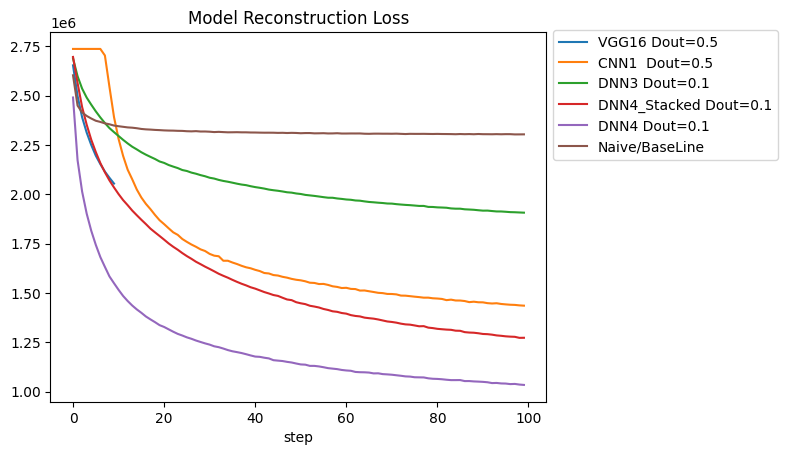

In [173]:

plt.clf()
pivot_Results.plot(x="step", y=pivot_Results.columns.tolist()[1:])
plt.title('Model Reconstruction Loss')
labels=["VGG16 Dout=0.5","CNN1  Dout=0.5","DNN3 Dout=0.1","DNN4_Stacked Dout=0.1","DNN4 Dout=0.1","Naive/BaseLine"]
plt.legend(labels=labels, bbox_to_anchor=(1,1.025), loc="upper left")
plt.show()